<a href="https://colab.research.google.com/github/helenalecluyse/tutorialPyTorch/blob/main/tutorial_colab_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: Pre-processing

## Import necessary packages

In [ ]:
import os

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms # Python has packages for specific domains: torchvision, torchaudio, torchtext. These include datasets among others.

## Data transformation and retrieval

Here we will use the MNIST dataset, which we can load using a dedicated PyTorch module 'Dataset'.
The Dataset module includes many built in datasets (full list: https://pytorch.org/vision/stable/datasets.html), but also supports custom datasets.
Upon calling this module we will specify data transformations we want to apply.

In the transforms.Compose function you can define other transformations to resize, centre or normalize the input data.
For example if you would want to use the pretrained AlexNet architecture, you need to adjust the data to fit the input of the network. https://pytorch.org/hub/pytorch_vision_alexnet/

In [ ]:
# Define a series of transformations to apply to the input images
transformations = transforms.Compose([
    # Convert the image to a PyTorch tensor. This also effectively changes the value range from 0-255 to 0-1.
    transforms.ToTensor(),
])

# We then download the data using the specified transformations
download_path = os.path.join("data") # Specify location to store MNIST data. This is an OS-friendly way of specifying the path. Change as desired.
# Create the folder if doesn't exist.
if not os.path.exists(download_path):
    os.makedirs(download_path)

# Create a dataset for training
train_data = datasets.MNIST(
    root= download_path,
    train=True,
    download=True,
    transform=transformations
)

# Create a dataset for testing (train=False!)
test_data = datasets.MNIST(
    root= download_path,
    train=False,
    download=True,
    transform=transformations
)

## PyTorch DataLoader
PyTorch has another module called DataLoader (https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
This module helps with sampling and iterating over the Dataset object created earlier. This also helps with sampling batches of images during training, instead of single images.
Additionally, it uses Python's multiprocessing functionality to sample data faster.

In [ ]:
# Specify the batch size
batch_size = 64

# Create dataloaders for the training and test datasets respectively
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

The DataLoader is a generator, meaning that it does not store its contents in memory (as with a Python list).
In order to access its contents we need to loop over it, or alternatively call a batch with next(iter(DataLoader object))

In [ ]:
# Printing the dataloader object directly won't show its contents. Instead you see where the object itself is stored in memory.
print(train_loader)

In [ ]:
# Adjust print output length for tensors
torch.set_printoptions(threshold=20, edgeitems=2)
# Let's have a look at what it yields.
sample = next(iter(train_loader))
sample

[tensor([[[[0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.],
           ...,
           [0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.]]],
 
 
         [[[0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.],
           ...,
           [0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.],
           ...,
           [0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.]]],
 
 
         [[[0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.],
           ...,
           [0., 0.,  ..., 0., 0.],
           [0., 0.,  ..., 0., 0.]]]]),
 tensor([3, 5,  ..., 9, 7])]

The Dataloader returns both the image data, and the corresponding labels.
Let's split these up and take a closer look at the structure of these variables.

In [ ]:
sample_images, sample_labels = next(iter(train_loader))
print(f"Sample_data shape: {sample_images.shape}")
print(f"Sample_labels shape: {sample_labels.shape}")

Sample_data shape: torch.Size([64, 1, 28, 28])
Sample_labels shape: torch.Size([64])


As you can see, both variables are batches of 64. The image has 1 channel (e.g., RGB requires 3) with a size of 28 by 28 pixels.
Looking at 'sample_labels', we can see it contains the true digit labels of the corresponding images.

In [ ]:
# Adjust print output length for tensors
torch.set_printoptions(threshold=20, edgeitems=5)
# Show tensor
sample_labels

tensor([8, 0, 0, 1, 7,  ..., 6, 4, 8, 7, 5])

Let's check the first image as an example


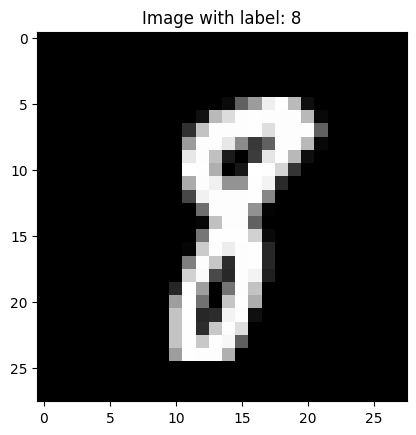

In [ ]:
im_id = 0

plt.imshow(sample_images[im_id].permute((1,2,0)), cmap='gray')
plt.title(f"Image with label: {sample_labels[im_id]}")
plt.show()

# STEP 2: Create the network

## Check Device for Training
Depending on your system, you can choose whether to train the network on your CPU (Central Processing Unit) or GPU (Graphical Processing Unit).
Choosing to run the training process on your GPU will significantly increase the training speed. In PyTorch you can set the device to 'cuda' (Compute Unified Device Architecture), which is a sort of software interface that allows for general purpose computing on certain types of GPUs.

However, if you choose to go for GPU processing, please note that created networks and tensors that interact with the network need to be sent to the GPU before they can be processed by the GPU.
This can be done using the command *var.to(device)*, where 'var' is a tensor or network object, and 'device' is set according to below code cell.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # Configures to cuda if it is available.
print(f"Using {device} device")

Using cuda:0 device


## The Network Architecture
Firstly, we need to define the network architecture. In other words, we need to define the amount and types of layers, in which order they are arranged, and how many inputs and outputs there are for each layer. Additionally, we define the activation functions that make the network non-linear. All this information is organized by defining a Python class, which structures the network. This class creates an object that contains the network's entire architecture, including its layers and activation functions.

- Flatten: transforms a 2d input to one dimension (see example below)
- Linear: fully connected layer
- ReLu: activation function to introduce non-linearity into the network, applies max(0,x)

The class we are writing inherits class attributes and functions from the nn.Module class (within the parentheses), which essentially makes it easier for us to define a trainable network.
When writing the code you have to first define the architecture under the \_\_init__ function. This code is run when you create an instance of the object. It is basically an initialization script (hence "\_\_init__").
We also need to initialize the nn.Module class that we inherit when we create an object from this class, this is what the super().\_\_init__() function does.

Lastly, the forward function defines the information flow from input to output. It is important to name this function as 'forward'.
This is because PyTorch uses the forward method internally when you call an instance of your network.


In [ ]:
#create network structure
class SimpleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


Example of how the Flatten function works

In [ ]:
sample_image, sample_label = next(iter(test_loader))
sample_image.to(device)
flatten = nn.Flatten().to(device)
output = flatten(sample_image)
output.size()

torch.Size([64, 784])

Example of how the ReLU activation function works.
This function allows the network to learn more complex patterns in the data, by introducing non-linearities. Furthermore, it helps with the vanishing gradient problem. This can occur during backpropagation, when the gradients that are used to update the network become close to 0 when going from the later to the earlier layers.
for more information about the ReLU function: https://medium.com/@meetkp/understanding-the-rectified-linear-unit-relu-a-key-activation-function-in-neural-networks-28108fba8f07


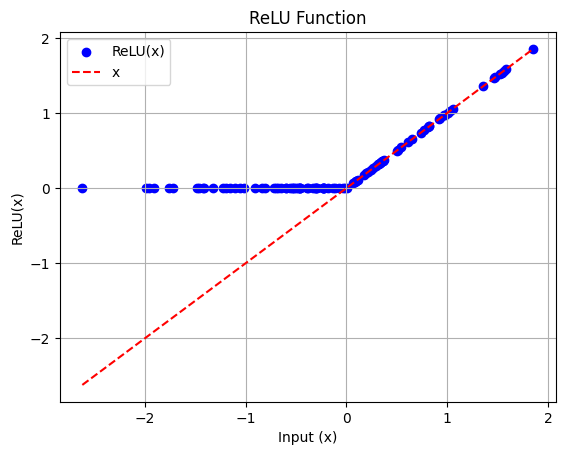

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the ReLU function
def relu(x):
    return np.maximum(0, x)

# Generate random data (100 points from a normal distribution)
np.random.seed(42)
random_data = np.random.normal(0, 1, 100)

# Apply the ReLU function to the random data
relu_data = relu(random_data)

# Plot the original data vs ReLU-transformed data
plt.scatter(random_data, relu_data, color='blue', label='ReLU(x)')
plt.plot(sorted(random_data), sorted(random_data), color='red', linestyle='dashed', label='x')
plt.title("ReLU Function")
plt.xlabel("Input (x)")
plt.ylabel("ReLU(x)")
plt.legend()
plt.grid(True)
plt.show()

## Convolutional Neural Network

To classify images (especially more naturalistic once) you might want to add convolutional layers to increase the performance of the network.
In the code cell below you see the architecture of a simple network with one convolutional layer.

If there is time left, we will come back to this and explain how it works. Otherwise, you can read through this explanation yourself if you are interested.

Inspired by the human visual system, a convolutional neural network (CNN) consists of hierarchical layers that extract features with an increasing receptive field.
Starting with the extraction of local features like lines and edges, the layers are increasingly able to detect parts, and then objects. In other words, higher-level features are derived from lower-level features, just like in the human visual system.

A CNN consists of convolutional layers that extract features from the previous layer, and pooling layers that group similar features into smaller units (see image). Pooling layers not only help with size reduction, but additionally help with making feature detection invariant to the position of the feature. After a series of convolutional and pooling layers the output arrives in the fully connected layers, which use the output to make a classification of the image.




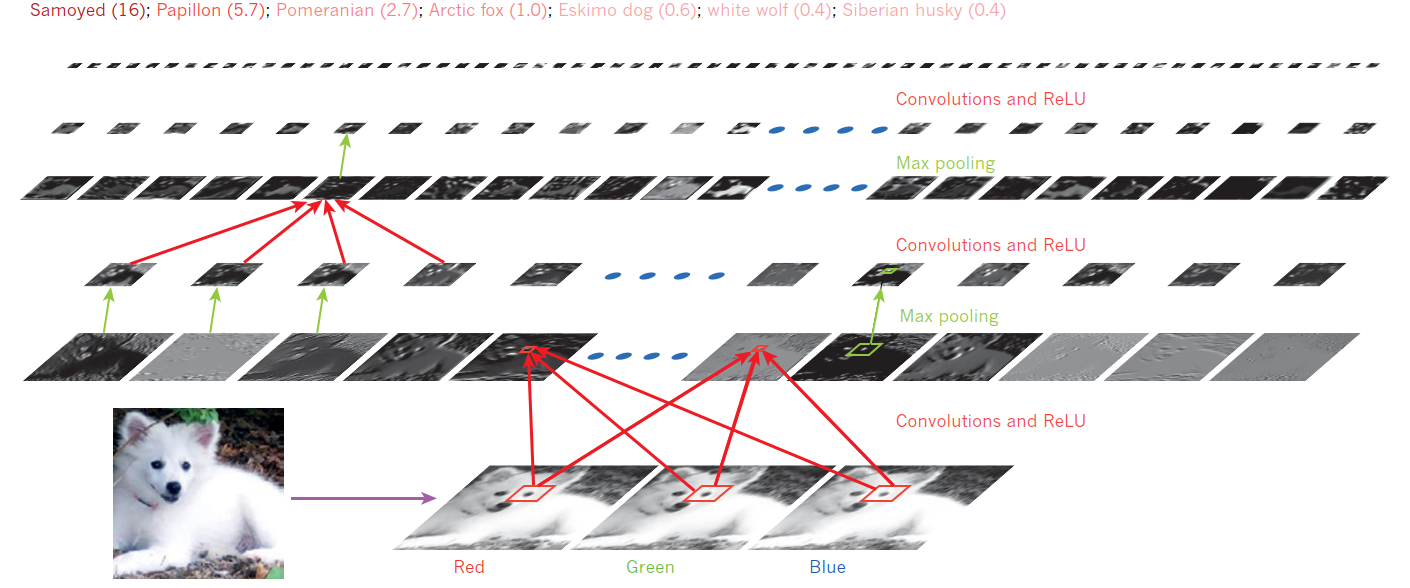

How do these layers work?

A convolutional layer detects features by applying small 2D rectangle filters (or kernels) to the previous layer (see below image).
The filter is essentially a matrix of trainable weights that you multiply with a set of pixels of an image. The output of this operation, as well as adding a bias parameter (also trainable) and putting all this through a ReLU function, is called a convolution (hence the name convolutional layer). This operation can be summarized as: $z=ReLU(\mathbf{w}^T\mathbf{x} + w_0)$, where $\mathbf{w}$ is the weight matrix, $\mathbf{x}$ the input matrix, and $w_0$ the bias parameter.

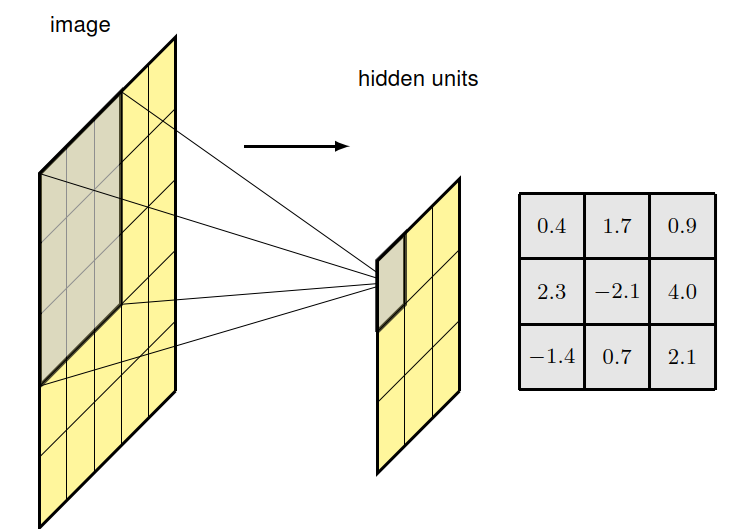

Using the filter to convolve across the whole image results in a feature map.
If we look at a single unit of this feature map in the images above and below, we can see that it corresponds to a certain region in the image. Since the weight matrix is shared across all units in this feature map, it is able to detect a specific feature across the whole image (e.g., vertical edges).

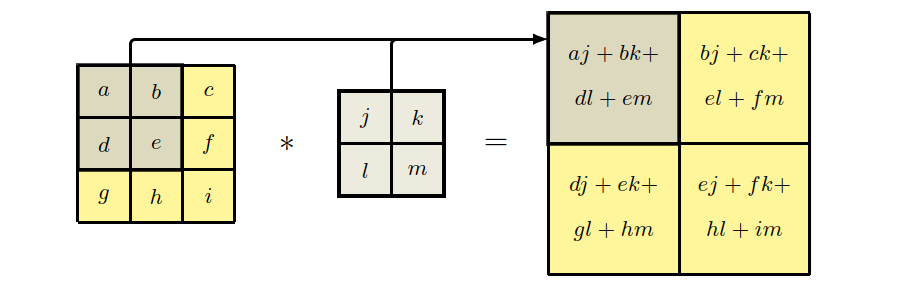

Above image shows an example of a 3x3 input image convolved with a 2x2 filter, resulting in a 2x2 feature map (not taking into account the non-linear activation function and bias parameter).

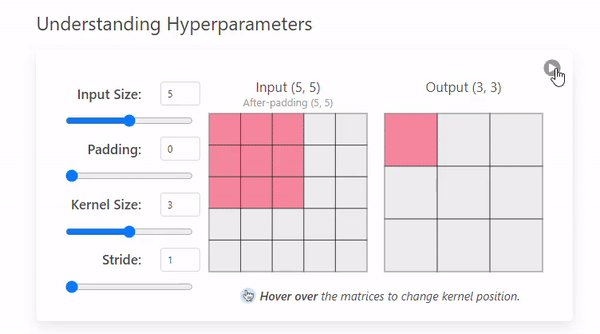


Below image shows an example of convolving an image with two different filters, one that detects vertical edges, the other horizontal edges.

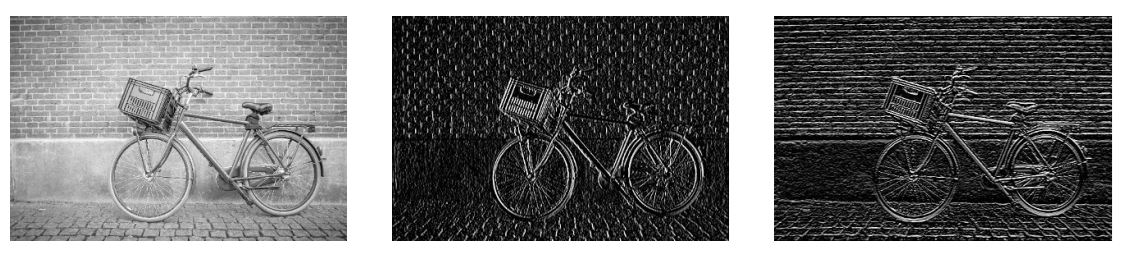

Small changes in the relative position of features should not affect classification. For example, a face is still a face if the eyes are positioned slightly differently.
To achieve such 'translational invariance', CNNs use pooling layers. The mechanism is quite simple and illustrated in below image. You take another 2D matrix of relatively small size with a certain receptive field size. Each unit in this 2D matrix will again correspond to a certain region in the input image. We then apply a function per unit in our pooling matrix, which commonly is to take the max value of what the unit sees in the previous image.

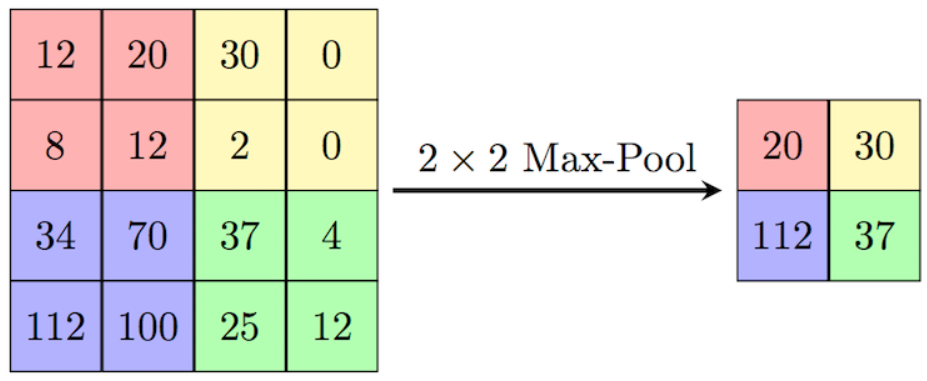

Now let's take a look at the network in the code cell below.
We implemented a single convolutional layer and a single pooling layer.

- nn.conv2d means that we have two dimensions.
    - in_channels = 1: for grayscale pictures ( this would be 3 in the case of coloured pictures (rgb)).
    - out_channels = 10: we will apply 10 filters
    - kernel_size = 3: these filters will have have a size of 3x3
    - stride = 1: we will move the filter by one pixel each time

- nn.BatchNorm2d is to normalize the output of a layer. This is important because the output from different layers can have different value ranges, which can complicate gradient descent training. This normalization is done each time the weights are updated during training and to each unit in that layer. Because weights only get updated after a mini-batch of input data, it is called batch normalization.
- next we apply a ReLu activation function to the output. In practice you can also choose to normalize after adding non-linearity.
- Laslty we apply Max Pooling, with size 3x3 and stride 2, which means that for each 3x3 square the network will only store the maximum value

In the forward part of the code, it is important to flatten the output from the convolutional layer, as the linear layer only takes one dimension as input.

If you want a more elaborate (and maybe clearer) explanation of how convolution works, you can check out this video:
https://www.youtube.com/watch?v=KuXjwB4LzSA&t=703s



<u>References:</u>

Bishop, C. M., & Bishop, H. (2023). Deep learning: Foundations and Concepts. Springer Nature.

LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. Nature, 521(7553), 436–444. https://doi.org/10.1038/nature14539

In [ ]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2)
            )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10*12*12, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = torch.flatten(x, 1)
        logits = self.linear_relu_stack(x)
        return logits

# Step 3: Prepare the training and testing of the network

Choose which network you want to use:

In [ ]:
#net = SimpleNeuralNetwork().to(device)
net = ConvNeuralNetwork().to(device)
print(net)

ConvNeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1440, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Define function to train the network
First we will define a function to train the network. This functions takes as input:
- the dataloader: in this case that will be the dataloader with the training data
- the network architecture
- the loss function, which computes the dissimilarity between the network's predictions (pred) and the actual answer (y)
- the optimizer functions, which computes the gradient based on the losses (dit moet anders verwoord zijn denk ik)
- the current epoch to track the network's performance

We set the network to training mode (net.train). This is very important because this allows gradients to be computed for the network parameters, during the forward and backward passes in the training. It also activates training-specific features like dropout and batch normalization to prevent overfitting and improve generalization when working with more complex networks.

For each batch in the dataloader:
1. we pass the input (X) through the network.
2. The loss function calculates the dissimilarities between the prediction and the actual answer (y).
3. the gradients of the losses are computed by taking the derivatives of the loss functions for each parameter (loss.backward).
4. The optimizer than adjusts the parameters with these gradients (optimizer_step)
5. the gradients are set back to zero to prevent the gradients to keep adding up across batches (optimizer.zero_grad).
6. for each 10 and 100 batches we track the losses/progress of the training



In [ ]:
def train_loop(dataloader, net, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    net.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device) # Send to device that is available (either GPU or CPU)

        # Compute prediction and loss
        pred = net(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #track the losses for visualization
        if batch % 10 == 0:
            train_losses.append(loss.item())
            train_counter.append((batch*64) + (epoch*len(dataloader.dataset)))

        #track progress of the training
        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")



## Define function to test the network:
Next we define a function to test the network. This function takes as input:
- the dataloader: in this case that will be the dataloader with the test data
- the network architecture
- the loss function
(we don't need the optimizer function, since we won't update the parameters anymore.)

We set the network to evaluation mode (net.eval), this is important because at this will disable dropout and will use the batch normalizations calculated during the training phase.

We initiate two empty variables to keep track of the network's performance

We evaluate the network with torch.no_grad() to ensure that no gradients are computed during test mode (this also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True).

We need both net.eval() and torch.no_grad() during the test phase since net.eval changes the state of the nn.Module whereas torch.no_grad is a context manager to work with the autograd engine.

We store the losses and correct answers to compute the accuracy and average loss of the network.


In [ ]:
def test_loop(dataloader, net, loss_fn):
    net.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device) # Send to device that is available (either GPU or CPU)
            pred = net(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_losses.append(test_loss)
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


# Step 4: Train the network

## Defining the hyperparameters
Start by defining the hyperparameters:
- epochs: the number of epochs = number of times that the training dataset is passed through the network
- learning rate: value indicating to which extent the network parameters are updated for each batch/epoch (smaller values lead to slower updating).
- loss function: PyTorch has different build in functions to calculate the losses
- optimizer function: PyTorch has different build in functions for optimization

Here we will use CrossEntropyLoss as the loss function. This function applies a softmax transformation to the networks output to obtain the predicted class probabilities. Afterwards it computes the negative log-likelihood loss between the predicted probabilities and the true labels.

For the optimizer we use stochastic gradient descent.

Next we will initiate a couple of empty lists to keep track of the network's performance

In [ ]:
#define hyperparameters
epochs = 3
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss() #this step applies the softmax transformation and can compare the output of the net with integers
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(epochs + 1)]

## Test the untrained network
First we test the untrained network, which performance do you expect?

In [ ]:
#test the untrained network
test_loop(test_loader, net, loss_fn)

Test Error: 
 Accuracy: 10.6%, Avg loss: 2.303682 



## Now everything is ready to train and test the network!
We use a for loop to repeat the process for n epochs using the functions we created previously.
After each training loop, we use the test loop to check the performance of the network.
Note that the network thus also sees the test data for several times.
To have a true evaluation of the network, you would actually need data that the network has never seen before (you could do this by splitting the data in the beginning when creating the dataloaders).

In [ ]:
#train the network
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, net, loss_fn, optimizer, t)
    test_loop(test_loader, net, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.325999  [   64/60000]
loss: 2.204816  [ 6464/60000]
loss: 2.103035  [12864/60000]
loss: 1.959187  [19264/60000]
loss: 1.867532  [25664/60000]
loss: 1.641778  [32064/60000]
loss: 1.492242  [38464/60000]
loss: 1.366147  [44864/60000]
loss: 1.093279  [51264/60000]
loss: 1.101672  [57664/60000]
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.949453 

Epoch 2
-------------------------------
loss: 0.968583  [   64/60000]
loss: 0.867561  [ 6464/60000]
loss: 0.699615  [12864/60000]
loss: 0.702679  [19264/60000]
loss: 0.628933  [25664/60000]
loss: 0.582694  [32064/60000]
loss: 0.630561  [38464/60000]
loss: 0.673204  [44864/60000]
loss: 0.381138  [51264/60000]
loss: 0.564269  [57664/60000]
Test Error: 
 Accuracy: 88.5%, Avg loss: 0.490890 

Epoch 3
-------------------------------
loss: 0.547766  [   64/60000]
loss: 0.601615  [ 6464/60000]
loss: 0.387994  [12864/60000]
loss: 0.536862  [19264/60000]
loss: 0.391375  [25664/60000]
loss: 0.380455  [32064/600

## Visualize the network's progress
Now we can create a graph to see how the losses of the network go down.

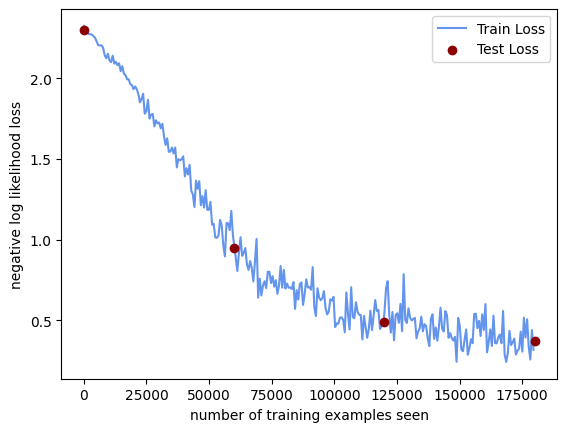

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(train_counter, train_losses, color='cornflowerblue', linewidth=1.5)
plt.scatter(test_counter, test_losses, zorder = 5, color='darkred')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

# Step 5: Save the network

Lastly, you can store the network in different ways, depending on whether you only want to save its architecture, or just the trained weights and biases.

The recommended way is to just store the parameters, because this allows for the most flexibility. Saving the entire network is less flexible and requires extra caution when working across devices.

## Saving and loading the parameters
This method will save just the trained parameters. Upon loading the network it is required to create an instance of the original network architecture and then load the parameters to this network.

In [ ]:
# Store the network parameters
torch.save(net.state_dict(), 'netMNIST_pars.pth')

In [ ]:
# This is how you load it
loaded_net = SimpleNeuralNetwork()
#loaded_net = ConvNeuralNetwork()
loaded_net.load_state_dict(torch.load("netMNIST_pars.pth", weights_only=True))
# Don't forget to put the network in evaluation mode
loaded_net.eval()

RuntimeError: Error(s) in loading state_dict for SimpleNeuralNetwork:
	Unexpected key(s) in state_dict: "conv.0.weight", "conv.0.bias", "conv.1.weight", "conv.1.bias", "conv.1.running_mean", "conv.1.running_var", "conv.1.num_batches_tracked". 
	size mismatch for linear_relu_stack.0.weight: copying a param with shape torch.Size([512, 1440]) from checkpoint, the shape in current model is torch.Size([512, 784]).

## Saving and loading the entire network

In [ ]:
#save  network
torch.save(net, 'netMNIST.pth')

#if you would want to load the network again
net = torch.load('netMNIST.pth')
